# HOMEWORK 14

In this homework we will be working with the Fashion MNIST dataset. You will be given a classifier which suffers from considerable overfitting. Your objective will be to employ regularization techniques to mitigate the overfitting problem.

Let's start with the usual imports.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

### Dataset

The MNIST fashgion dataset [link](https://github.com/zalandoresearch/fashion-mnist) was build by Zalando Reasearch tem consists of monochrome images of different type of clothing, namely:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

It is also one of the Keras built-in datasets. Let's load the images and quickly inspect it.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


Let's visualise some random samples.

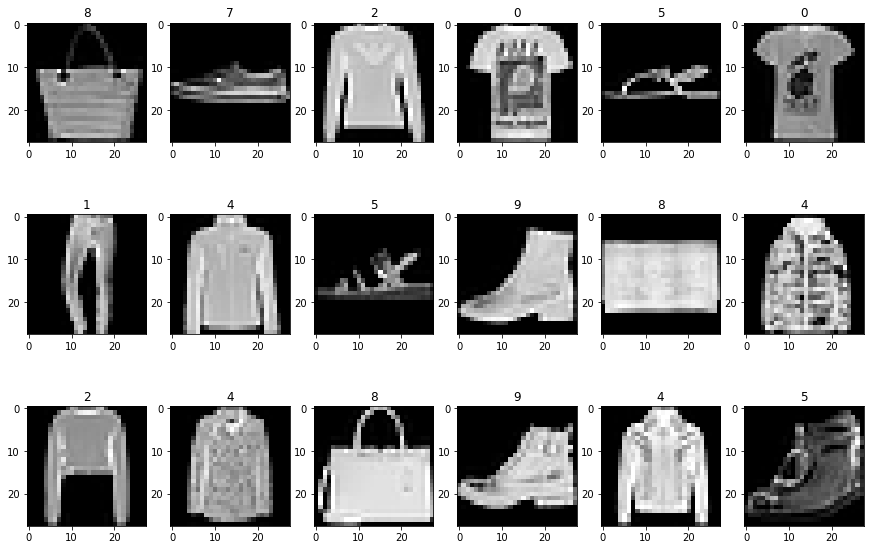

In [ ]:
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

### Building the Classifier

We are now going to build the baseline classifier that you will use throughout this homework.

In [ ]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [ ]:
inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Flatten()(net)
net = Dense(128)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/50
938/938 [==============================] - 14s 4ms/step - loss: 0.3936 - accuracy: 0.8622 - val_loss: 0.3316 - val_accuracy: 0.8803
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2702 - accuracy: 0.9040 - val_loss: 0.2948 - val_accuracy: 0.8922
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2325 - accuracy: 0.9155 - val_loss: 0.2992 - val_accuracy: 0.8938
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2028 - accuracy: 0.9257 - val_loss: 0.3079 - val_accuracy: 0.8956
Epoch 5/50
938/938 [==============================] - 3s 4ms/step - loss: 0.1801 - accuracy: 0.9341 - val_loss: 0.3135 - val_accuracy: 0.8966
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1617 - accuracy: 0.9406 - val_loss: 0.3097 - val_accuracy: 0.9002
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1446 - accuracy: 0.9465 - val_loss: 0.3263 - val_accuracy: 0.8970
Epoch

Train Acc      0.9953500032424927
Validation Acc 0.8840000033378601


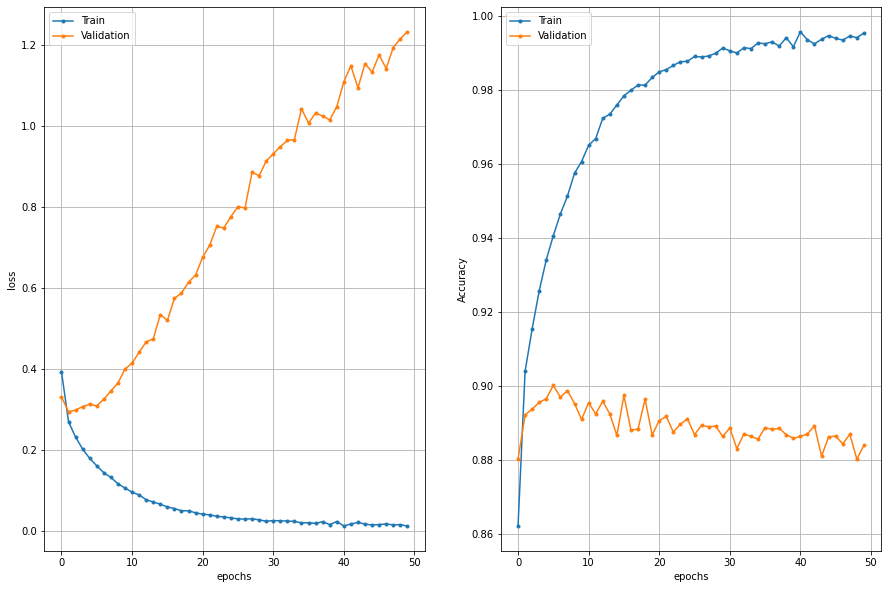

In [ ]:
plot_history(history)

As you can see, the classifier suffers from massive overfitting. The validation accuracy is around 88% while the training accuracy is close to 1.

### Combat the Overfitting!

Now it is your turn. Use the classifier as a baseline, include some regularization techniques and try to improve the classification performance. You can try any techniques you might see fit, e.g.,
* Dropout
* Batch normalization
* Weight regularization
* Data augmentation
* Early stopping
* Pooling
* Reducing the number of parameters (the size of the network)
* ...

There are to objective you shall fulfill in order to successfully complete this homework:
* The validation accuracy shall be above 91%
* Your network (with all the regularizations applied) shall **not** be larger than the baseline

`Let's convert y data to the categorical vectors, split the train dataset to train and validation datasets and convert them to the Tensorflow dataset objects (including the test dataset)`

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_data, y_data), (x_test, y_test) = fashion_mnist.load_data()

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Transform y labels to categorical
y_data = to_categorical(y_data)
y_test = to_categorical(y_test)

# Split original training data to sub-training (80%) and validation data (20%)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=13)

# Prepare the training validation and test images
train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(x_train, -1), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(x_val, -1), y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(x_test, -1), y_test))

`Convert datasets to Tensorflow batch loaders (piplines), normalize them and define the augmentation functions`

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness # Resizing, Rescaling, RandomHeight, RandomWidth, RandomCrop, RandomBrightness, RandomContrast

def mix_with_augmentation(*args):
    threshold = 0
    augmentation_probability = tf.random.uniform(shape=())
    image = args[0]
    # tf.print(augmentation_probability)
    if augmentation_probability > threshold:
        augmentation_type = tf.random.uniform(shape=(), minval=0, maxval=4, dtype=tf.dtypes.int32)
        # tf.print(augmentation_type)
        if augmentation_type == 0:
            image = RandomFlip("horizontal")(image, training=True)
        elif augmentation_type == 1:
            image = RandomRotation(factor=(-0.05, 0.05), fill_mode="constant")(image, training=True)
        elif augmentation_type == 2:
            image = RandomTranslation(height_factor=(-0.25, 0.25), width_factor=(-0.25, 0.25), fill_mode="constant")(image, training=True)
        elif augmentation_type == 3:
            image = RandomZoom(height_factor=(0, 0.7), width_factor=(0, 0.7), fill_mode="constant")(image, training=True)
    args = list(args)
    args[0] = image
    return tuple(args)

def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
# train_dataset = train_dataset.map(mix_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

`Let's modificate previous model. We add max pooling and dropout layers after the convolutional layer and relu activation to the penultimate dense layer.`

In [ ]:
# Create a model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import L2

tf.keras.backend.clear_session()

inputs = Input(shape=(28, 28, 1))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

net = Flatten()(net)
net = Dense(128, activation='relu')(net)

outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                             

`Do the 10-epochs training without the augmentation`

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
750/750 [==============================] - 7s 6ms/step - loss: 0.4307 - accuracy: 0.8484 - val_loss: 0.3331 - val_accuracy: 0.8782
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2960 - accuracy: 0.8944 - val_loss: 0.2928 - val_accuracy: 0.8938
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2602 - accuracy: 0.9040 - val_loss: 0.2634 - val_accuracy: 0.9068
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2298 - accuracy: 0.9154 - val_loss: 0.2556 - val_accuracy: 0.9082
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2082 - accuracy: 0.9230 - val_loss: 0.2716 - val_accuracy: 0.9039
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1900 - accuracy: 0.9303 - val_loss: 0.2470 - val_accuracy: 0.9144
Epoch 7/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1742 - accuracy: 0.9346 - val_loss: 0.2591 - val_accuracy: 0.9121
Epoch 

`Let's see the results.. Looks like we just catch the start of overfitting!`

Train Acc      0.9515416622161865
Validation Acc 0.9125000238418579
157/157 [==============================] - 1s 4ms/step - loss: 0.2776 - accuracy: 0.9103
Test loss   0.2776370048522949
Test metric 0.9103000164031982


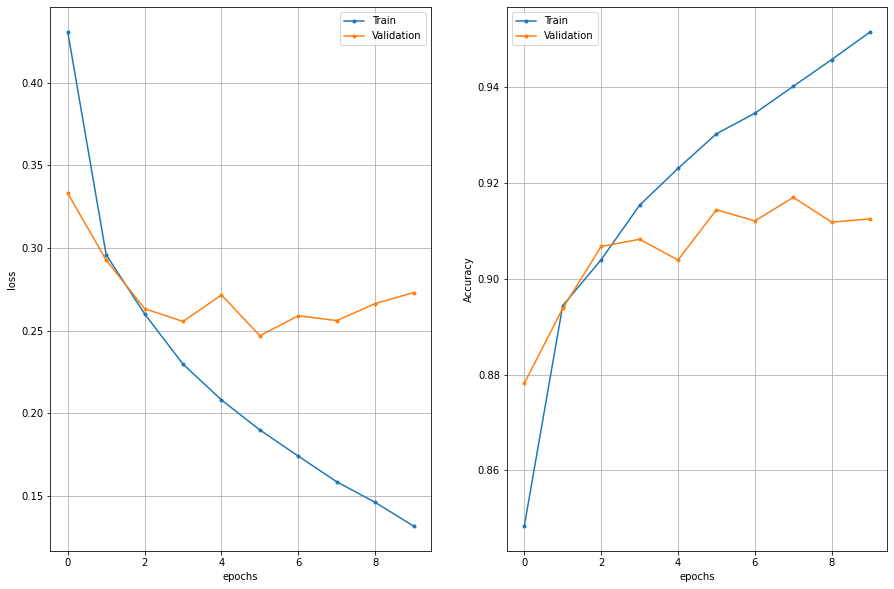

In [ ]:
# Show the results
plot_history(history)

# Print the overall stats
ev = model.evaluate(test_dataset)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

`Add the data augmentation function to the train dataset loader pipeline`

In [ ]:
train_dataset = train_dataset.map(mix_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

`Let's see what does this function do..`

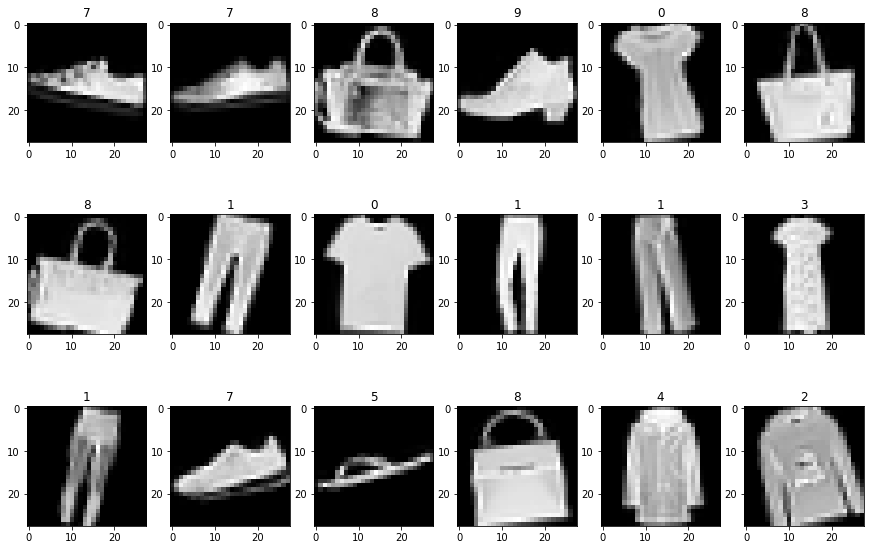

In [ ]:
for idx, element in enumerate(train_dataset.unbatch().take(18)):
    img = (element[0].numpy() * 255).astype("uint8").squeeze()
    label = np.argmax(element[1].numpy())
    plt.subplot(3,6,idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    if idx >= 3*6-1:
        break

`And do the 50 epochs training with the augmentation and with the early stopping function`

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[es]
)

Epoch 1/50
750/750 [==============================] - 12s 16ms/step - loss: 0.5806 - accuracy: 0.7922 - val_loss: 0.2653 - val_accuracy: 0.9063
Epoch 2/50
750/750 [==============================] - 12s 16ms/step - loss: 0.4456 - accuracy: 0.8362 - val_loss: 0.2531 - val_accuracy: 0.9133
Epoch 3/50
750/750 [==============================] - 12s 16ms/step - loss: 0.4143 - accuracy: 0.8459 - val_loss: 0.2504 - val_accuracy: 0.9133
Epoch 4/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3948 - accuracy: 0.8530 - val_loss: 0.2464 - val_accuracy: 0.9146
Epoch 5/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3797 - accuracy: 0.8597 - val_loss: 0.2532 - val_accuracy: 0.9134
Epoch 6/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3680 - accuracy: 0.8631 - val_loss: 0.2470 - val_accuracy: 0.9134
Epoch 7/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3639 - accuracy: 0.8628 - val_loss: 0.2441 - val_accuracy:

`Looks like early stopping stops the fitting at the 17-th epoch. Let's see the results with evaluation the test dataset`

Train Acc      0.8849166631698608
Validation Acc 0.9170833230018616
157/157 [==============================] - 0s 3ms/step - loss: 0.2491 - accuracy: 0.9185
Test loss   0.24908721446990967
Test metric 0.9185000061988831


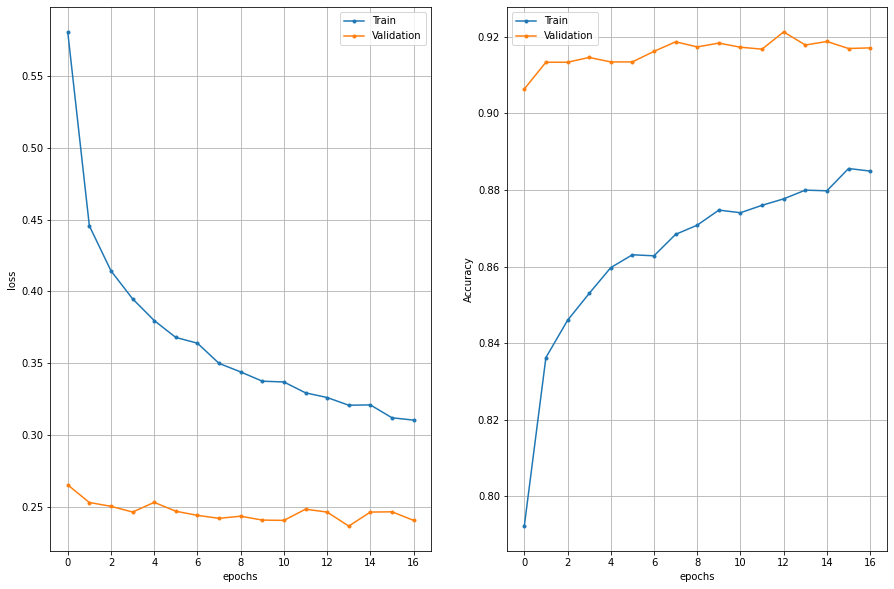

In [ ]:
# Show the results
plot_history(history)

# Print the overall stats
ev = model.evaluate(test_dataset)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

`Great! Accuracy is quite 92%. Let's evaluate the network..`

In [ ]:
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.argmax(np.concatenate([y for x, y in test_dataset], axis=0), axis=1)
x_test = np.concatenate([x for x, y in test_dataset], axis=0)

correct = np.nonzero(y_pred==y_true)[0]
incorrect = np.nonzero(y_pred!=y_true)[0]

157/157 [==============================] - 0s 2ms/step


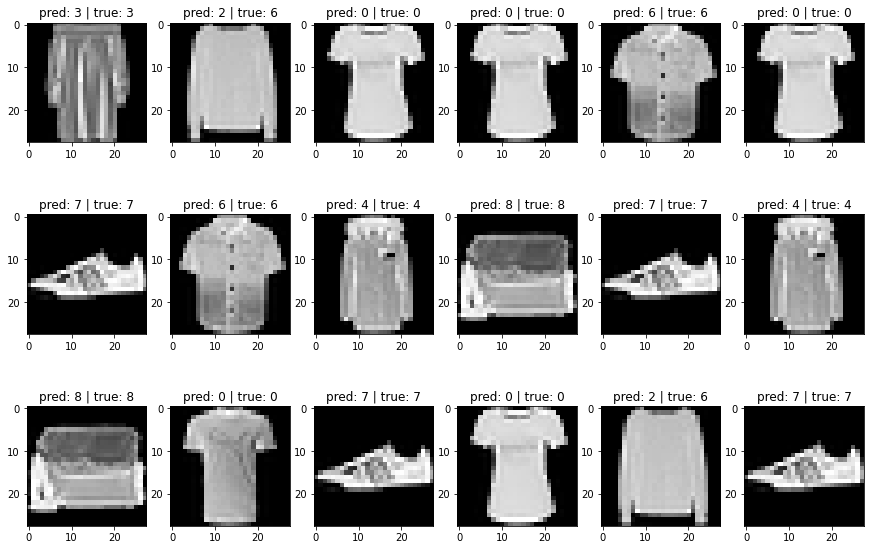

In [ ]:
grid = (3,6)
shift = tf.random.uniform(shape=(), minval=0, maxval=len(y_pred)-grid[0]*grid[1], dtype=tf.dtypes.int32)
for idx, pred_idx in enumerate(y_pred):
    img = x_test[pred_idx + shift].reshape(28,28)
    label = "pred: {} | true: {}".format(y_pred[pred_idx + shift], y_true[pred_idx + shift])
    plt.subplot(grid[0],grid[1],idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    if idx >= grid[0]*grid[1]-1:
        break

`The true preditions examples:`

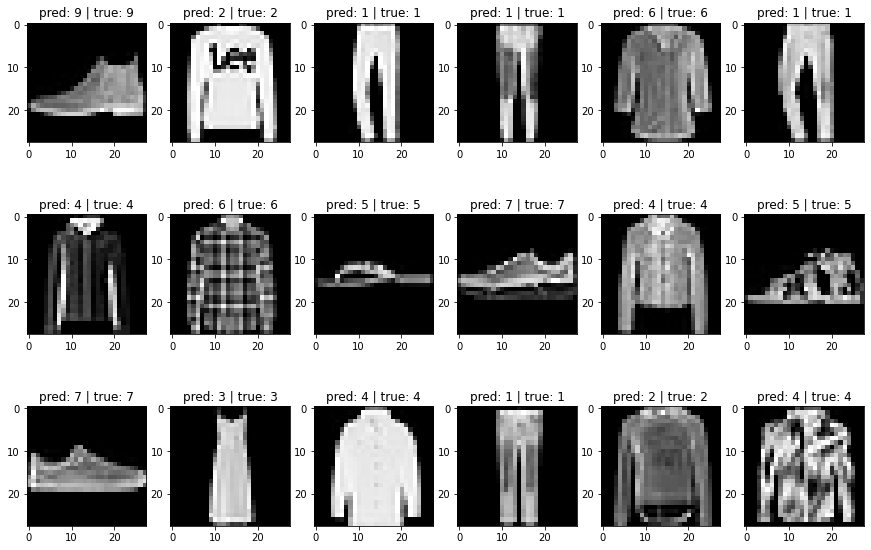

In [ ]:
grid = (3,6)
shift = 0 # tf.random.uniform(shape=(), minval=0, maxval=len(correct)-grid[0]*grid[1], dtype=tf.dtypes.int32)
for idx, pred_idx in enumerate(correct):
    img = x_test[pred_idx + shift].reshape(28,28)
    label = "pred: {} | true: {}".format(y_pred[pred_idx + shift], y_true[pred_idx + shift])
    plt.subplot(grid[0],grid[1],idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    if idx >= grid[0]*grid[1]-1:
        break

`The false preditions examples:`

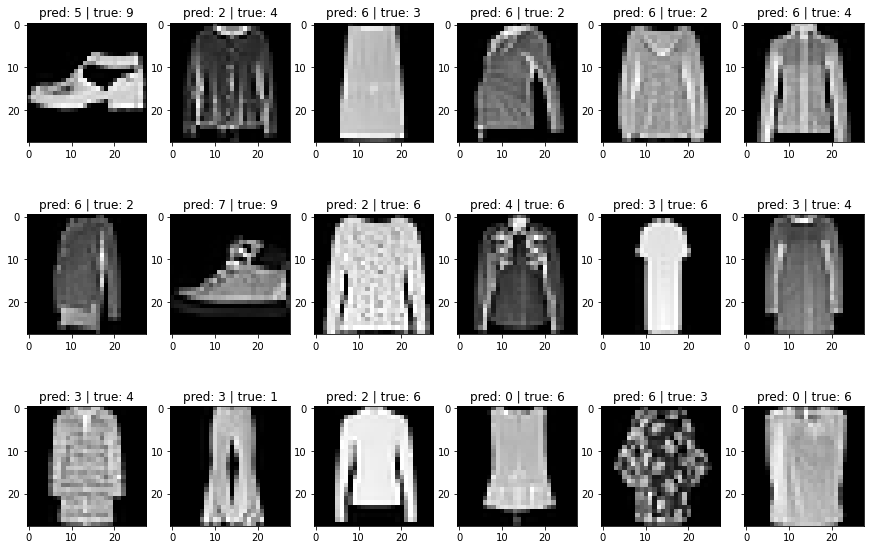

In [ ]:
grid = (3,6)
shift = 0 # tf.random.uniform(shape=(), minval=0, maxval=len(incorrect)-grid[0]*grid[1], dtype=tf.dtypes.int32)
for idx, pred_idx in enumerate(incorrect):
    img = x_test[pred_idx + shift].reshape(28,28)
    label = "pred: {} | true: {}".format(y_pred[pred_idx + shift], y_true[pred_idx + shift])
    plt.subplot(grid[0],grid[1],idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    if idx >= grid[0]*grid[1]-1:
        break

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.87      0.85      0.86      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.88      0.86      0.87      1000
     Class 3       0.88      0.95      0.92      1000
     Class 4       0.86      0.88      0.87      1000
     Class 5       0.99      0.98      0.98      1000
     Class 6       0.79      0.75      0.77      1000
     Class 7       0.95      0.98      0.97      1000
     Class 8       0.98      0.99      0.98      1000
     Class 9       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



`Looks like the network has the worst accuracy with the 6-th class (sandals) `

### Questions

* What have you done in order to improve the performance?

```
The main things are:

  * Converting the y-data (labels) to the categorical vectors

  * Splitting train dataset to train (80%) and validation (20%) datasets. The test dataset will use for the post evaluating only.

  * Modificating the model adding max pooling and dropout layers after the convolutional layer and relu activation to the penultimate dense layer

  * Doing the 10-epochs training without the augmentation and the 50 epochs training with the augmentation + early stopping function
```

* Have you tried configurations that did not work out?

```
Yes, I tried some configs witch worked a little bit worse:

  * BatchNormalization after the flatten and dense layers - 89.85% accuracy
  
  * L2 regularazer in the convolutional layer - 91.21% accuracy

  * 50% mix augmentation data with original from 1-st epoch (early stopped at the 19-th epoch) - 90.88% accuracy

  * etc
```